Original implementation of graph-sc method
(https://github.com/ciortanmadalina/graph-sc)

In [1]:
import sys
sys.path.append("..")
import argparse
import numpy as np
import dgl
from dgl import DGLGraph
import torch
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import h5py
import random
import glob2
import seaborn as sns

import train
import models

%load_ext autoreload
%autoreload 2

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
device = train.get_device()

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
path= "../"
# check available files
!ls ../real_data

Using backend: pytorch
/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)
/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


10X_PBMC.h5			 Quake_Smart-seq2_Lung.h5
Adam.h5				 Quake_Smart-seq2_Trachea.h5
Muraro.h5			 Romanov.h5
Quake_10x_Bladder.h5		 Young.h5
Quake_10x_Limb_Muscle.h5	 mouse_ES_cell.h5
Quake_10x_Spleen.h5		 mouse_bladder_cell.h5
Quake_Smart-seq2_Diaphragm.h5	 worm_neuron_cell.h5
Quake_Smart-seq2_Limb_Muscle.h5


In [2]:
# select dataset to analyze
dataset = 'Quake_Smart-seq2_Trachea'

In [3]:
data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
X = np.array(data_mat['X'])
Y = np.array(data_mat['Y'])
print("Sparsity: ", np.where(X ==0)[0].shape[0]/(X.shape[0]*X.shape[1]))
normalize_weights = "log_per_cell"

n_layers = 1
hidden_dim = 200
hidden = [300]
nb_genes = 3000
activation = F.relu
epochs = 10
batch_size = 128 
pca_size = 50

Sparsity:  0.854844741489701


In [4]:
# remove less variable genes
genes_idx, cells_idx = train.filter_data(X, highly_genes=nb_genes)
X = X[cells_idx][:, genes_idx]
Y = Y[cells_idx]
n_clusters = len(np.unique(Y))

# create graph
graph = train.make_graph(
    X,
    Y, # Pass None of Y is not available for validation
    dense_dim=pca_size,
    normalize_weights=normalize_weights,
)
labels = graph.ndata["label"]
train_ids = np.where(labels != -1)[0]

# create training data loader
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(n_layers)
dataloader = dgl.dataloading.NodeDataLoader(
    graph,
    train_ids,
    sampler,
    batch_size=batch_size,
    shuffle=True,
    drop_last=False,
    num_workers=1,
)

# create model
model = models.GCNAE(
    in_feats=pca_size,
    n_hidden=hidden_dim,
    n_layers=n_layers,
    activation=activation,
    dropout=0.1,
    hidden=hidden,
).to(device)

optim = torch.optim.Adam(model.parameters(), lr=1e-5)
# train model
results = train.train(model,
                     optim,
                     epochs,
                     dataloader,
                     n_clusters,
                     plot=False,
                     save = True,
                     cluster=["KMeans", "Leiden"])

/opt/conda/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)



ARI 0.8863, 0.4554443955421448


In [5]:
results.keys()

dict_keys(['ae_end', 'features', 'y', 'kmeans_ari', 'kmeans_nmi', 'kmeans_sil', 'kmeans_cal', 'kmeans_pred', 'kmeans_time', 'leiden_ari', 'leiden_nmi', 'leiden_sil', 'leiden_cal', 'leiden_pred', 'leiden_time', 'aris_kmeans'])

# Visualize results

In [6]:
X_embedded = TSNE(n_components=2).fit_transform(results["features"])

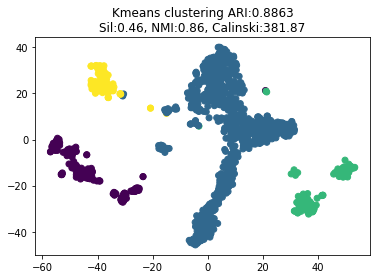

In [7]:
plt.scatter(X_embedded[:,0],X_embedded[:,1], c = results['kmeans_pred'])
plt.title(f"Kmeans clustering ARI:{results['kmeans_ari']}\n"+
          f"Sil:{round(float(results['kmeans_sil']),2)}, NMI:{results['kmeans_nmi']}, "+
          f"Calinski:{round(float(results['kmeans_cal']),2)}"
         );

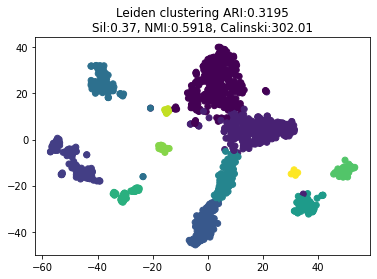

In [8]:
plt.scatter(X_embedded[:,0],X_embedded[:,1], c = results['leiden_pred'])
plt.title(f"Leiden clustering ARI:{results['leiden_ari']}\n"+
          f"Sil:{round(float(results['leiden_sil']),2)}, NMI:{results['leiden_nmi']}, "+
          f"Calinski:{round(float(results['leiden_cal']),2)}"
         );